原始图像尺寸: 742 x 980
缩放后尺寸: 742 x 980
正在调用 qwen3-vl 进行检测...
API 返回结果: ```json
[
	{"bbox_2d": [317, 458, 610, 702], "label": "mushroom"},
	{"bbox_2d": [546, 509, 720, 651], "label": "mushroom"}
]
```
检测到 2 个蘑菇
相对坐标: [317, 458, 610, 702] -> 像素坐标: [235, 448, 452, 687]
相对坐标: [546, 509, 720, 651] -> 像素坐标: [405, 498, 534, 637]

提取的 BBoxes: [[235, 448, 452, 687], [405, 498, 534, 637]]
提取的 Labels: ['mushroom', 'mushroom']

正在使用 SAM 进行实例分割...

0: 1024x1024 1 0, 1 1, 1297.5ms
Speed: 14.7ms preprocess, 1297.5ms inference, 2.1ms postprocess per image at shape (1, 3, 1024, 1024)
SAM 分割完成，生成 2 个掩码


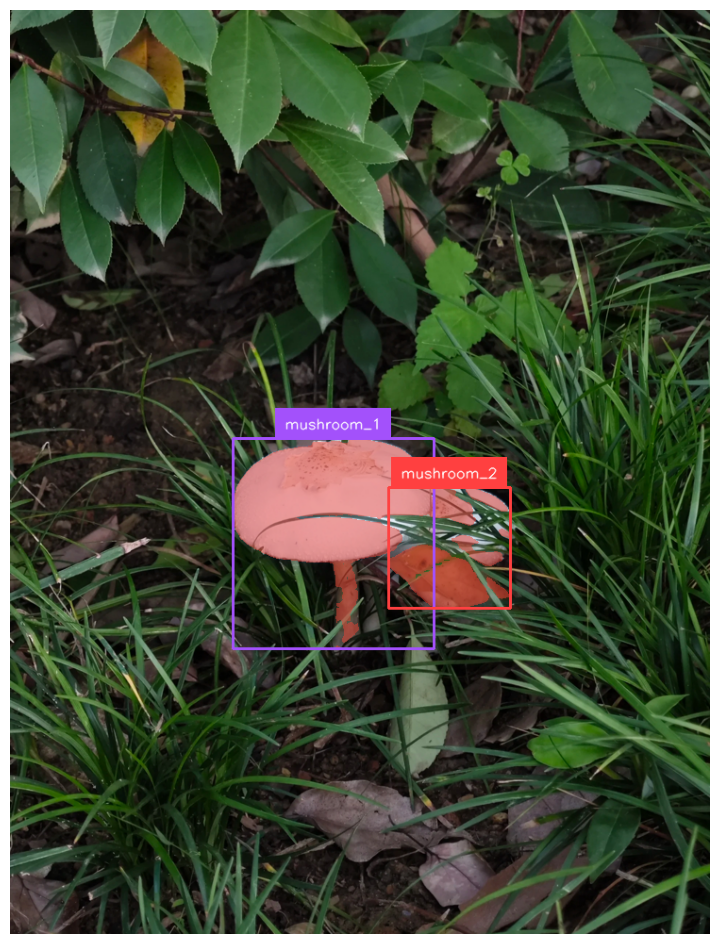

In [4]:
from PIL import Image
from openai import OpenAI
import os, io, base64, json
from dotenv import load_dotenv
import supervision as sv
from ultralytics import SAM
from openai.types.shared_params import ResponseFormatJSONObject

load_dotenv()

# ==================== 配置 ====================
wh = (1024, 1024)  # 图片缩略图尺寸

# OpenRouter 客户端
client = OpenAI(
    api_key=os.getenv("OPENROUTER_API_KEY"),
    base_url=os.getenv("OPENROUTER_BASE_URL"),
)

# SAM 模型
sam_model = SAM("sam2.1_b.pt")

# ==================== 1. 使用 qwen3-vl 进行对象检测 ====================
prompt = '''
Locate every mushroom in the image. For each mushroom, report bbox coordinates and label in JSON format like this: 
[
    {"bbox_2d": [x1, y1, x2, y2], "label": "mushroom"},
    {"bbox_2d": [x1, y1, x2, y2], "label": "mushroom"}
]
'''

# 读取图片
image_path = "./IMG_2566.PNG"
img = Image.open(image_path)

# 保存原始尺寸
original_size = img.size
print(f"原始图像尺寸: {original_size[0]} x {original_size[1]}")

# 缩放图片
img.thumbnail(wh)
resized_size = img.size
print(f"缩放后尺寸: {resized_size[0]} x {resized_size[1]}")

# 转换为 base64
byte_io = io.BytesIO()
img.save(byte_io, format='PNG')
base64_str = base64.b64encode(byte_io.getvalue()).decode('utf-8')

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": prompt,
            },
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{base64_str}"}
            }
        ],
    }
]

# 调用 API
response_format: ResponseFormatJSONObject = {"type": "json_object"}
detections = None

try:
    print("正在调用 qwen3-vl 进行检测...")
    completion = client.chat.completions.create(
        model="qwen/qwen3-vl-235b-a22b-instruct",
        max_tokens=4096,
        temperature=0.3,
        messages=messages,
        response_format=response_format,
    )
    result = completion.choices[0].message.content
    print(f"API 返回结果: {result}")
    
    # 解析 JSON
    detections = json.loads(result.strip().removeprefix('```json').removeprefix('```').removesuffix('```').strip())
    
    print(f"检测到 {len(detections)} 个蘑菇")
    
except Exception as e:
    print(f"[错误] 调用 API 或解析 JSON 时出错: {e}")
    raise e

# ==================== 2. 坐标转换：相对坐标 -> 像素坐标 ====================
img_w, img_h = resized_size

bboxes_list = []
labels_list = []

for det in detections:
    # qwen3-vl 返回的是 [0, 1000] 范围的相对坐标
    x1_rel, y1_rel, x2_rel, y2_rel = det["bbox_2d"]
    
    # 转换为实际像素坐标
    x1 = int(x1_rel / 1000 * img_w)
    y1 = int(y1_rel / 1000 * img_h)
    x2 = int(x2_rel / 1000 * img_w)
    y2 = int(y2_rel / 1000 * img_h)
    
    # 确保坐标在有效范围内
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(img_w, x2), min(img_h, y2)
    
    bboxes_list.append([x1, y1, x2, y2])
    labels_list.append(det.get("label", "mushroom"))
    
    print(f"相对坐标: [{x1_rel}, {y1_rel}, {x2_rel}, {y2_rel}] -> 像素坐标: [{x1}, {y1}, {x2}, {y2}]")

print(f"\n提取的 BBoxes: {bboxes_list}")
print(f"提取的 Labels: {labels_list}")

# ==================== 3. 使用 SAM 进行实例分割 ====================
print("\n正在使用 SAM 进行实例分割...")
results = sam_model.predict(img, bboxes=bboxes_list)
detections_sv = sv.Detections.from_ultralytics(results[0])

print(f"SAM 分割完成，生成 {len(detections_sv)} 个掩码")

# ==================== 4. 可视化结果 ====================
# 创建标注器
mask_annotator = sv.MaskAnnotator(
    color=sv.Color.from_hex("#ea4335"),  # 红色掩码
    color_lookup=sv.ColorLookup.INDEX,
    opacity=0.5
)

box_annotator = sv.BoxAnnotator(
    color_lookup=sv.ColorLookup.INDEX, 
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX, 
    text_position=sv.Position.TOP_CENTER,
    text_thickness=1,
    text_scale=0.5
)

# 生成标签（添加编号）
numbered_labels = [f"{label}_{i+1}" for i, label in enumerate(labels_list)]

# 在图片上绘制掩码、边界框和标签
annotated_image = mask_annotator.annotate(
    scene=img.copy(),
    detections=detections_sv
)

annotated_image = box_annotator.annotate(
    scene=annotated_image,
    detections=detections_sv
)

annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections_sv,
    labels=numbered_labels
)

# 显示和保存结果
sv.plot_image(annotated_image)
